# Flower recognition using CNN
using transfer learning
---




In [1]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od
import os
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torch.utils.data import random_split
import torch
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
dataset_url = 'https://www.kaggle.com/datasets/alxmamaev/flowers-recognition'

In [3]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: errtika
Your Kaggle Key: ··········


100%|██████████| 225M/225M [00:11<00:00, 20.5MB/s]


##import the dataset into pytorch

use the `ImageFolder` class from `torchvision`

In [39]:
data_dir = './flowers-recognition/flowers'

In [40]:
os.listdir(data_dir)

['sunflower', 'tulip', 'daisy', 'rose', 'dandelion']

In [41]:
for cls in os.listdir(data_dir):
  print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

sunflower : 733
tulip : 984
daisy : 764
rose : 784
dandelion : 1052


In [42]:
dataset = ImageFolder(data_dir)

In [43]:
dataset = ImageFolder(data_dir,tt.Compose([tt.Resize(64),
                                           tt.RandomCrop(64),
                                           tt.ToTensor()]))

In [44]:
#validation and train set sizes
val_pct=0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(3886, 431)

In [45]:
#spliting the dataset
train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(3886, 431)

In [46]:
#creating dataloaders of batches of size 128
train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)


batch_size = 128
train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)
val_dl = DataLoader(valid_ds,
                    batch_size,
                    num_workers=4,
                    pin_memory=True)

### Utiity functions and classes / GPU utilities


In [47]:

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [48]:
torch.cuda.is_available()

True

In [49]:
device = get_default_device()

In [50]:
device

device(type='cuda')

In [51]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)

### Transfer learning

In [52]:
import torchvision.models as models

class ResNet34(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()

        # Load a pre-trained ResNet model
        # resnet
        # pretrained model on imageNet dataset
        self.network = models.resnet34(pretrained=pretrained)

        # Modify the final fully connected layer for the number of output classes
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, x):
        # Forward pass through the base model
        x = self.network(x)
        return x





In [70]:
model = to_device(ResNet34(len(dataset.classes), pretrained=True), device)

In [71]:
model

ResNet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [55]:
import torchvision.transforms as tt
## aligning the dataset with ImageNet trained model
img_size = 224
## first is the mean values of RGB pixel in ImageNet dataset (on which it has been pretrained)
## second is stanadard deviation
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.335])

dataset = ImageFolder(data_dir,tt.Compose([tt.Resize(img_size),
                                           tt.RandomCrop(img_size),
                                           tt.ToTensor(), tt.Normalize(*imagenet_stats)]))



In [56]:
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader


train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)


batch_size = 64
train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)
val_dl = DataLoader(valid_ds,
                    batch_size,
                    num_workers=4,
                    pin_memory=True)

In [57]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)

In [58]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [72]:
history =[evaluate(model, valid_dl)]
history

[{'val_loss': 1.7961688041687012, 'val_acc': 0.20065538585186005}]

In [73]:
history += fit_one_cycle(5, 0.0001, model, train_dl, valid_dl, weight_decay=0.01
              , grad_clip=0.1, opt_func=torch.optim.Adam)

  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.9629, val_loss: 0.2852, val_acc: 0.9069


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.1984, val_loss: 0.2344, val_acc: 0.9203


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.0841, val_loss: 0.2139, val_acc: 0.9284


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.0374, val_loss: 0.1661, val_acc: 0.9479


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.0210, val_loss: 0.1738, val_acc: 0.9470


In [61]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');


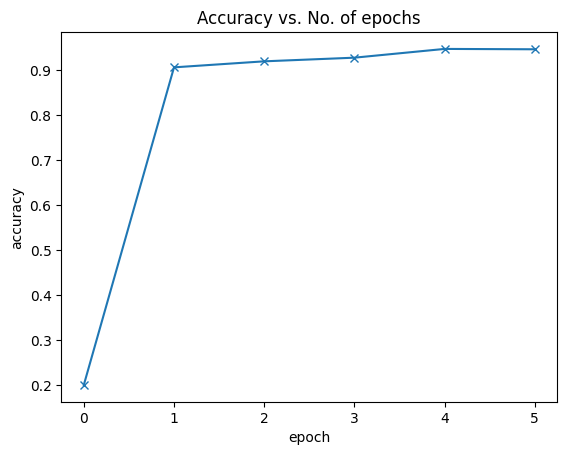

In [74]:
plot_accuracies(history)

In [63]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-gx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

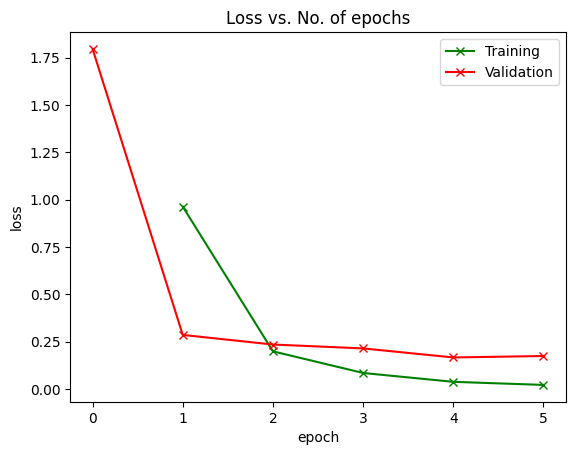

In [75]:
plot_losses(history)

In [65]:
import numpy as np
def plot_lrs(history):

    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Finder')

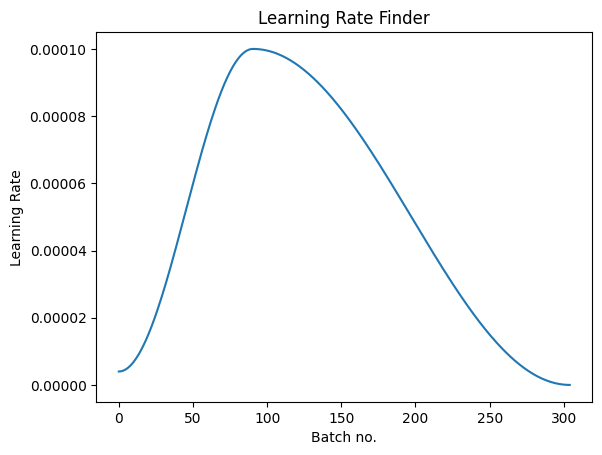

In [76]:
plot_lrs(history)

In [67]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0) # add dimension so it is (1, 3, 1, 1)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

In [77]:
def predict_image(img, model, classes):
    # Convert to a batch of 1 cause our model works with batches
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: dandelion (1)
Predicted:  dandelion


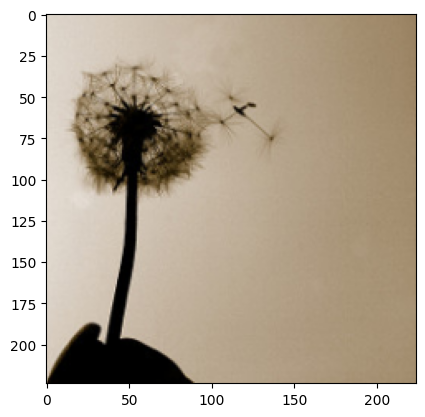

In [78]:
img, label = valid_ds[179]
show_image(img,label)
pred = predict_image(img, model, dataset.classes)
print('Predicted: ', pred)


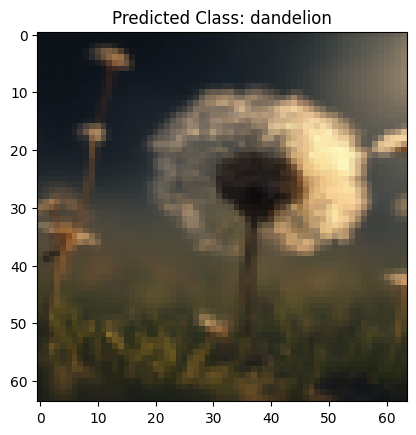

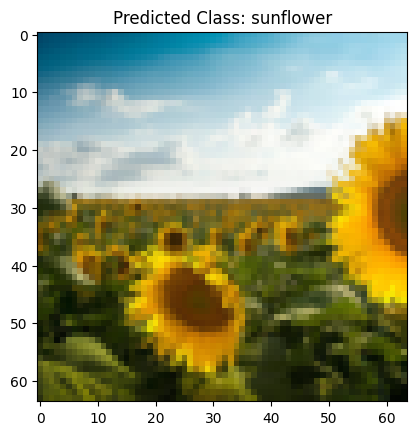

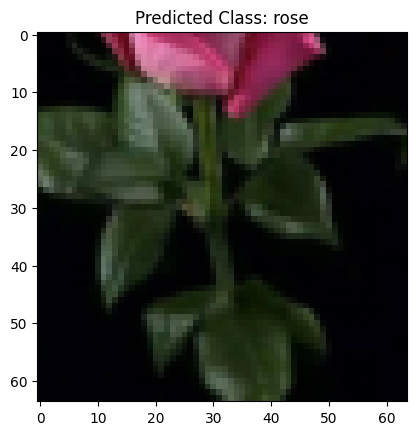

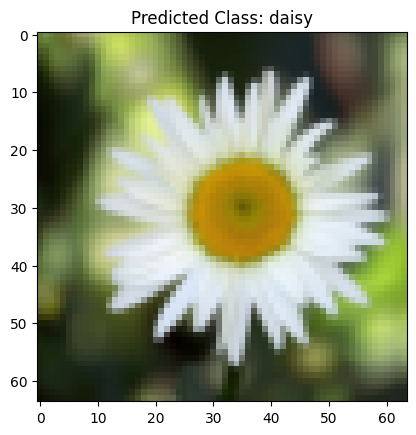

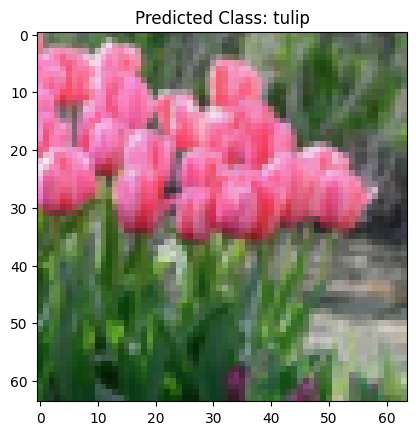

In [80]:
##########################for manually uploaded image####################
from PIL import Image

paths = [
         '/content/test/dandlion2.jpg',
         '/content/test/sunflower.jpg',
         '/content/test/rose.jpg',
         '/content/test/daisy.jpg',
         '/content/test/tulip.jpeg']

for path in paths:
    transform = tt.Compose([tt.Resize(64), tt.RandomCrop(64), tt.ToTensor()])
    image = Image.open(path)
    image = transform(image)

    # Assuming 'predict_image' is your function for making predictions
    predicted_class = predict_image(image, model, dataset.classes)

    # Display the image with the predicted class
    plt.imshow(image.permute((1, 2, 0)))
    plt.title(f'Predicted Class: {predicted_class}')
    plt.show()
